  # Alignment in Transformers: A Simple Coding Tutotrial #

# Part 1: #

In this coding tutorial we will see how transformers learn to align words between languages during translation and try to demonstrate the core mechanism behind how transformers handle translation, answering questions and many other tasks. So follow along!

Lets consider a simple task of translating a short english sentence 'The cat' to 'El gato' in Spanish.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Translation: "The cat" -> "El gato"
english = ["The", "cat"]
spanish = ["El", "gato"]

As we know, when we type a sentence, it goes into the input layer of the transformer where the textual prompt undergoes tokenization (broken into small pieces of words) and are combined with positional encodings, called as embeddings.

Here we will manually create the embeddings for our sentence to keep things simple.

Embeddings are basically the numerical reprsentations of words.

For the english sentence:
* [1.0, 0.0] represents "The"
* [0.0, 1.0] represents "cat"

And for the Spanish sentence:
* [0.9, 0.1] represents "El"
* [0.1, 0.9] represents "gato"

In [2]:
# Embeddings
english_emb = torch.tensor([[1.0, 0.0], [0.0, 1.0]])  # The, cat
spanish_emb = torch.tensor([[0.9, 0.1], [0.1, 0.9]])  # El, gato

Now, we need to calculate similarity scores. We do this by multiplying each english embeding with each spanish embedding. This will result in a 2x2 matrix, where, the higher the result the more similarity between the words.

In [3]:
# Calculate Similarity Score
scores = torch.matmul(english_emb, spanish_emb.T)

The maths:
* "The" $\cdot$ "El" = (1.0x0.9) + (0.0x0.1) = 0.9 (high similarity!)
* "The" $\cdot$ "gato" = (1.0x0.1) + (0.0x0.9) = 0.1 (low similarity)
* "cat" $\cdot$ "El" = (0.0x0.9) + (1.0x0.1) = 0.1 (low similarity)
* "cat" $\cdot$ "gato" = (0.0x0.1) + (1.0x0.9) = 0.9 (high similarity!)

Next, we convert the scores to alignment probabilities using the Softmax function.
Softmax converts the numerical scores to probabilities between 0 and 1.

In [4]:
alignment = F.softmax(scores, dim=-1)

And now we can visualize our results using a heatmap.

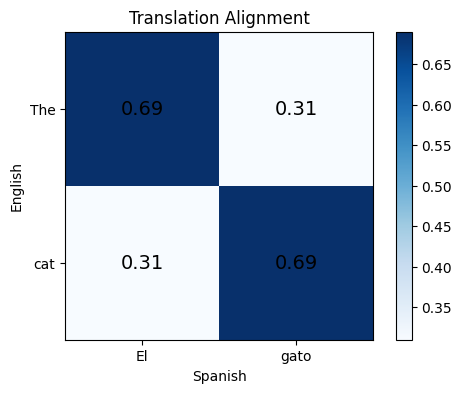

In [5]:
# heatmap
plt.figure(figsize=(6, 4))
plt.imshow(alignment, cmap='Blues')
plt.colorbar()

# Labels
plt.xticks(range(2), spanish)
plt.yticks(range(2), english)
plt.xlabel('Spanish')
plt.ylabel('English')
plt.title('Translation Alignment')

# Show values
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{alignment[i,j]:.2f}',
                ha='center', va='center', fontsize=14)

plt.show()

The results show that:
* "The" pays 69% attention to "El" and 31% to "gato"
* "cat" pays 69% attention to "gato" and 31% to "El"

Therefore, we can see that articles align with articles: "The" <--> "El"

Nouns align with Nouns: "cat" <--> "gato"

And the alignments between "The" and "gato" are weak.

In a transformer, the model learns these alignments automatically during training where multiple attention heads learn different types of alignments.

The beauty of this process is that the transformer doesnt need to be told that "The" should align with "El", it figures this out by looking at lots of translation examples and learning that similar words tend to align!

#Part 2: #

In this part of the tutorial, we will explore how alignment occurs in Transformers using a small pretrained model.

We will go through the following steps:

1. Load a small pretrained model 'BERT' and tokenize a short sentence

2. Extract hidden states from every layer

3. Compute and visualize with simple plots, alignment of singular directions and the **Line-Shape Score (LSS)**

In [6]:
# 1. Setup
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import numpy as np

# Load pretrained model 'BERT'
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

Now that we have loaded our model, lets **tokeinze** a simple sentence: "Welcome to the future"

We tokenize this sentence and pass it through BERT.

By using 'output_hidden_state', we can inspect the embeddings produced at every layer.

In [ ]:
## 2. Tokenize the simple sentence:
sentence = "Welcome to the future"
inputs = tokenizer(sentence, return_tensors="pt")

## And extract the hidden states

with torch.no_grad():
    outputs = model(**inputs)
    hidden_states = outputs.hidden_states  # tuple: one tensor per layer

print(f"Number of layers (including embedding): {len(hidden_states)}")
print(f"Shape of each layer output: {hidden_states[0].shape}")


Number of layers (including embedding): 13
Shape of each layer output: torch.Size([1, 6, 768])


Next, we will look how the embeddings of each token grow in norm as we pass through the layers. The embeddings are supposed to grow in an exponential form.

$$ ||x^{(t)}|| = Ce^{\lambda t}$$


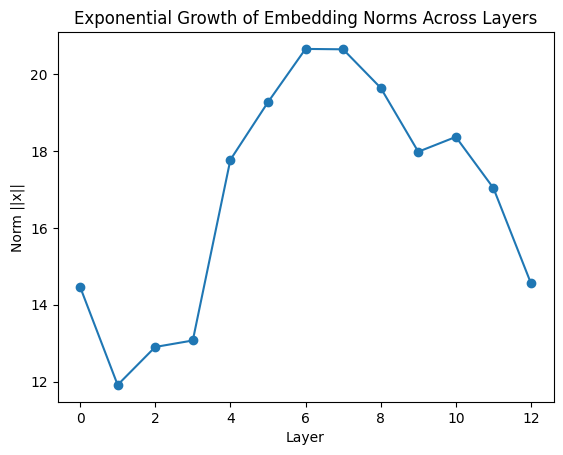

In [ ]:
## Using CLS token representation (index 0) at each layer

cls_embeddings = [h[0,0,:].numpy() for h in hidden_states]
norms = [np.linalg.norm(v) for v in cls_embeddings]

plt.figure()
plt.plot(range(len(norms)), norms, marker='o')
plt.title("Exponential Growth of Embedding Norms Across Layers")
plt.xlabel("Layer")
plt.ylabel("Norm ||x||")
plt.show()


It can be observed that from the layers 1 to 6 the embedding norms grow exponentially.

Now we will compute **Singular Vector alignment**.

For this tutorial instead of using Jacobians we will approximate alignment by looking at the principal direction of variance via **PCA (Principal Component Analysis)** in each layers token embeddings.

[https://en.wikipedia.org/wiki/Principal_component_analysis]


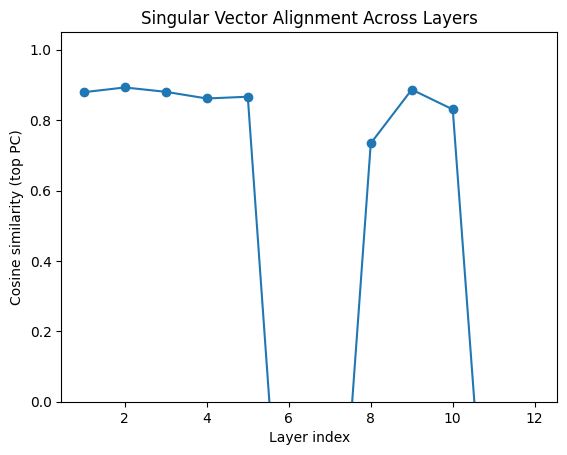

In [ ]:
## 4. Singular vector alignment

from sklearn.decomposition import PCA

## Stacking all token embeddings from a layer -> Perform PCA -> take top singular vector
pcs = []
for h in hidden_states:
    X = h[0,:,:].numpy()  # tokens x dim
    pca = PCA(n_components=1)
    pca.fit(X) # performing PCA
    pcs.append(pca.components_[0])  # top Principal component

## Computing alignment: cosine similarity of top PCs between consecutive layers
cos_sims = [np.dot(pcs[i], pcs[i+1]) for i in range(len(pcs)-1)]

plt.figure()
plt.plot(range(1, len(pcs)), cos_sims, marker='o')
plt.title("Singular Vector Alignment Across Layers")
plt.xlabel("Layer index")
plt.ylabel("Cosine similarity (top PC)")
plt.ylim(0,1.05)
plt.show()


As you can see from the above plot, most of the directions stay consistent across layers, hence we can say that the model has low misalignment.

In the end, we will compute the **Line-Shape Score (LSS)**, to check whether the trajcetory of the embeddings across layers is linear.

The LSS is given by:

$$  LSS = \frac{||\Delta^2x(t)||}{||\Delta x(t)||} $$

Its important to note that:

*   If embeddings move in a straight line -> LSS is small
*   If they curve a lot across the layers -> LSS is larger

We will compute this using finite differences in the embeddings and also make a visualization by plotting the trajectory in 2D PCA space.



Line-Shape Score (LSS): 1.2703


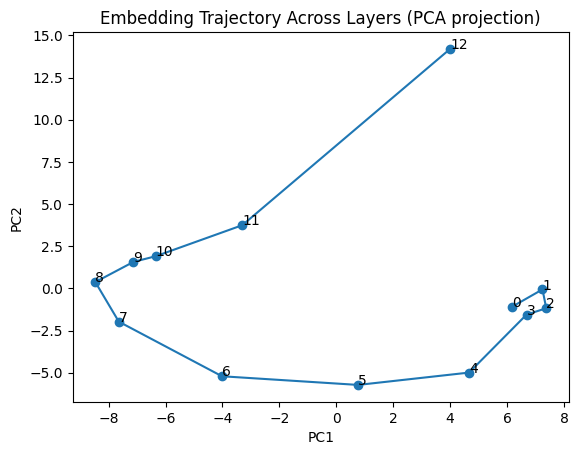

In [ ]:
## 5. Line-Shape Score (LSS) for trajectory linearity
cls_embeddings = np.array(cls_embeddings)  # (layers x dim)

## First and Second Differences
dx = np.diff(cls_embeddings, axis=0)
d2x = np.diff(dx, axis=0)

LSS = np.sum(np.linalg.norm(d2x, axis=1)) / np.sum(np.linalg.norm(dx, axis=1))
print(f"Line-Shape Score (LSS): {LSS:.4f}")

## Visualization: PCA projection of CLS trajectory
pca = PCA(n_components=2)
proj = pca.fit_transform(cls_embeddings)

plt.figure()
plt.plot(proj[:,0], proj[:,1], marker='o')
for i, (x, y) in enumerate(proj):
    plt.text(x, y, str(i))  # layer index
plt.title("Embedding Trajectory Across Layers (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Summary Part 2:

As we have seen,
* Norm growth shows embeddings often scale expoentially with depth
* Singular vector alignment shows dominant transformation directions remain consistent
* LSS shows embeddings move in nearly straight line trajectories across layers

These are all properties that show Alignment is a measurable, mathematical phenomenon in Transformers.